In [267]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)
par_get_daily_pred
par_get_all_signal
get_signal_stat

<function helper.get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str='2018', reverse=1, tranct=0.00011, max_spread=0.61, tranct_ratio=True, min_pnl=2, min_num=20, atr_filter=0, HEAD_PATH='d:/intern', SIGNAL_PATH='d:/intern')>

In [268]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [269]:
product_list = ["btc.usd.td", "eth.usd.td", "btc.usdt", "eth.usdt"]

In [270]:
period = 4096

In [271]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1059

1059

In [361]:
SAVE_PATH = "e:/intern"
all_dates_x = os.listdir(DATA_PATH + product_list[0])
all_dates_y = os.listdir(DATA_PATH + product_list[1])
all_dates = np.array(list(set(all_dates_x) & set(all_dates_y)))
all_dates.sort()
train_sample = all_dates<"2019-09"
test_sample = all_dates>"2019-09"
date_str = [n[0:10] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [273]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [274]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002"])
n_signal = len(signal_list)

In [276]:
train_sample = all_dates<"2019-08"
test_sample = all_dates>"2019-08"
date_str = [n[0:10] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
print(sum(train_sample))
print(sum(test_sample))
format_dates[test_sample][0]

122
92


Timestamp('2019-08-02 00:00:00')

In [277]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
#y_signal = "ret."+str(period)+".004"
y_signal = "ret."+str(period)

- at first we try using lasso for them together 

In [278]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-4]
signal_names
col_names = ori_mat.columns

In [279]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = train_mat[signal_names]
#train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=signal_names)
train_mat.shape
## (4470, 28)

(4470, 28)

In [280]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=col_names)
print(product_list[0], train_mat.shape)
for product in product_list[1:2]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

# btc.usd.td (4470, 32)
# eth.usd.td (3801, 32)




btc.usd.td (4470, 32)
eth.usd.td (3801, 32)


In [285]:
train_std_mat = dict([])
for product in product_list[0:2]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [288]:
x_train = train_mat.iloc[:, :n_signal].values
#x_train = train_mat[result["chosen.signals"]]
#x_train = train_mat[signal_list[chosen_signals]]
y_train = train_mat.loc[:, y_signal].values
print(np.shape(x_train))
scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
fit_coef = np.zeros(n_signal)
#fit_coef[pos] = model.coef_/x_std
fit_coef = model.coef_/x_std
print(fit_coef)

# (8271, 28)
# [ 0.0155054   0.00570079  0.02440753 -0.         -0.07424719  0.
#   0.          0.06562325 -0.00528303 -0.          0.          0.09833834
#   0.         -0.05236299  0.01675821  0.          0.16193953  0.
#  -0.          0.         -0.19170497 -0.         -0.         -0.
#  -0.          0.         -0.         -0.03495968]




(8271, 28)
[ 0.0155054   0.00570079  0.02440753 -0.         -0.07424719  0.
  0.          0.06562325 -0.00528303 -0.          0.          0.09833834
  0.         -0.05236299  0.01675821  0.          0.16193953  0.
 -0.          0.         -0.19170497 -0.         -0.         -0.
 -0.          0.         -0.         -0.03495968]


In [290]:
coef_list=dict([])
for product in product_list[:2]:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][signal_names]
    coef_list[product] = coef
    print(product)
    print(coef[coef!=0])
    
# btc.usd.td
# nr.4096                   0.001117
# dbook.4096                0.001771
# range.pos.4096            0.001346
# ma.dif.10.4096           -0.107693
# nr.range.4096             0.000097
# dbook.range.4096         -0.000022
# ma.dif.10.range.4096      0.000473
# kdj.j.range.4096         -0.000011
# nr.std.4096               0.000090
# range.pos.std.4096        0.000378
# kdj.j.std.4096           -0.000137
# kdj.j.trend.index.4096   -0.000941
# dtype: float64
# eth.usd.td
# nr.4096                   0.002321
# dbook.4096                0.003363
# range.pos.4096            0.002009
# ma.dif.10.4096           -0.068967
# nr.range.4096             0.002435
# dbook.range.4096         -0.000670
# ma.dif.10.range.4096      0.002446
# kdj.j.range.4096         -0.000247
# nr.std.4096               0.001970
# range.pos.std.4096        0.007456
# kdj.j.std.4096           -0.002631
# kdj.j.trend.index.4096   -0.001530
# dtype: float64

btc.usd.td
nr.4096                   0.001117
dbook.4096                0.001771
range.pos.4096            0.001346
ma.dif.10.4096           -0.107693
nr.range.4096             0.000097
dbook.range.4096         -0.000022
ma.dif.10.range.4096      0.000473
kdj.j.range.4096         -0.000011
nr.std.4096               0.000090
range.pos.std.4096        0.000378
kdj.j.std.4096           -0.000137
kdj.j.trend.index.4096   -0.000941
dtype: float64
eth.usd.td
nr.4096                   0.002321
dbook.4096                0.003363
range.pos.4096            0.002009
ma.dif.10.4096           -0.068967
nr.range.4096             0.002435
dbook.range.4096         -0.000670
ma.dif.10.range.4096      0.002446
kdj.j.range.4096         -0.000247
nr.std.4096               0.001970
range.pos.std.4096        0.007456
kdj.j.std.4096           -0.002631
kdj.j.trend.index.4096   -0.001530
dtype: float64


In [291]:
SAVE_PATH = "e:/intern"
save(coef_list, SAVE_PATH+"/crypto.lasso.pkl")

In [292]:
coef_list = load(SAVE_PATH+"/crypto.lasso.pkl")

In [293]:
strat = "overall.crypto.lasso."+str(period)
for product in product_list:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [294]:
%%time
for product in product_list[0:2]:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")

# btc.usd.td
# eth.usd.td
# Wall time: 5min 51s




btc.usd.td
eth.usd.td
Wall time: 5min 51s


In [295]:
%%time
for product in product_list[:2]:
    print(product)
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

# btc.usd.td
# eth.usd.td
# Wall time: 23.6 s


btc.usd.td
eth.usd.td
Wall time: 23.6 s


In [299]:
%%time
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("overall.crypto.lasso", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, "e:/intern",
                    period=4096, split_str="2019-08", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# Wall time: 3min 41s



reverse=1
reverse=1
Wall time: 7min 9s


btc.usd.td train sharpe  0.7425249105347431 test sharpe  1.64623314079153
eth.usd.td train sharpe  1.556446751716841 test sharpe  2.80912912895812
train sharpe:  1.5375444085862857 test sharpe:  2.0349401250749484


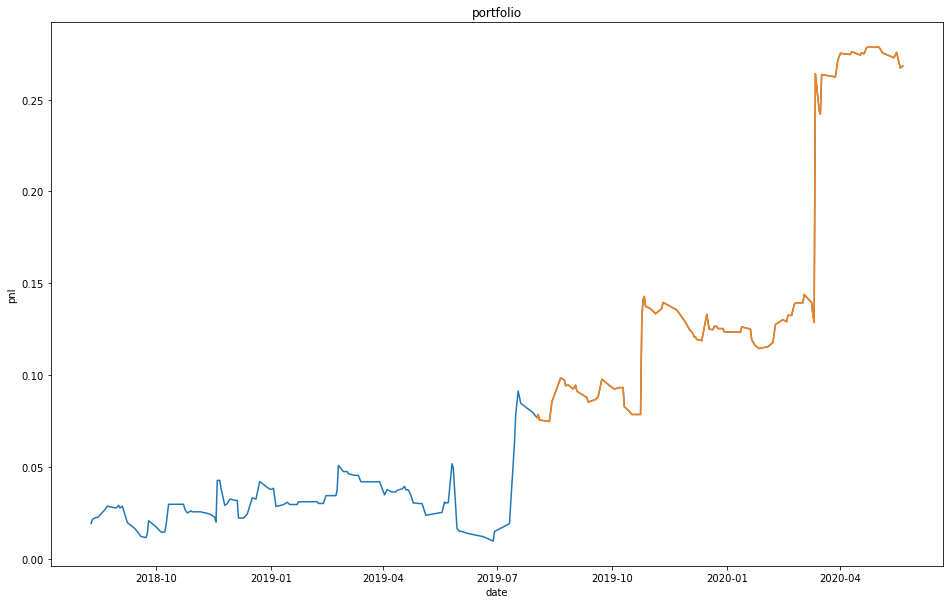

In [302]:
i = 0
strat = "overall.crypto.lasso.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 4
min_num = 10
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

# IF train sharpe  0.5382723555283818 test sharpe  0.9297478470109406
# IH train sharpe  0.3015850553271201 test sharpe  -0.2627275976746257
# IC train sharpe  0.5217126788528591 test sharpe  0.8105542278366956
# train sharpe:  0.6174139012165428 test sharpe:  0.6998230576278767






- we can see that the result is much better than before
- so we can use this method for rolling models
- However, using the previous method may be too slow
- we calcualte the predictions values of each product using 26 mintues, and other time add up together would be 30 mintues
- if we are rolling on a monthly basis
- from 201801 to 201908 there are 20 months
- so it may use 10 hours for the rolling

- rolling model

- at first we need to know how many ticks every day

In [303]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list[0:2]:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

- at first we can try a not so intensive method
- we can get the starting day for train

In [304]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV

- at first we can try a not so intensive method
- we can get the starting day for train

In [305]:
from sklearn.preprocessing import StandardScaler

- now we generate prediction values for next 22 days

- now we can combien all these and get a function for rolling
- we can also use calendar month rather than 22 days

In [310]:
month = np.array([file[:7] for file in all_dates])

In [311]:
month_len = np.unique(month, return_counts=True)
month_len
# (array(['2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01',
#         '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
#         '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01',
#         '2020-02', '2020-03', '2020-04', '2020-05'], dtype='<U7'),
#  array([ 7, 10, 10, 14, 11, 11, 10, 12, 14, 10,  6,  7, 10,  8, 11,  6, 14,
#          6, 10, 11,  9,  7], dtype=int64))

(array(['2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01',
        '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
        '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01',
        '2020-02', '2020-03', '2020-04', '2020-05'], dtype='<U7'),
 array([ 7, 10, 10, 14, 11, 11, 10, 12, 14, 10,  6,  7, 10,  8, 11,  6, 14,
         6, 10, 11,  9,  7], dtype=int64))

In [339]:
## training multiple products together with rolling model
## train_start: start day to train
## train_end: end day to train
## forward_len: length of test sets
## strat: name of strategy
## single_product: the products that need to train separately
## combine_product: the products that need to train together
def get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat, 
                          single_product, combine_product, period=4096, SAVE_PATH="e:/intern"):
    product_list = np.append(single_product, combine_product) ## all of the products
    cum_daily_ticks = dict([]) ## cumulative of number of ticks by product
    train_tick_start = dict([]) ## startting ticks of training set
    train_tick_end = dict([])   ## ending ticks of training set
    test_tick_start = dict([]) ## startting ticks of test set
    test_tick_end = dict([]) ## ending ticks of test set
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    for product in product_list:
        cum_daily_ticks[product] = daily_ticks[product].cumsum()
        if train_start==0:
            train_tick_start[product] = 0
        else:
            train_tick_start[product] = int(cum_daily_ticks[product][train_start-1]+1)
        train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1) 
        ## the last tick would use future data that in the test sample for response variable y, so we need to minus 1 here
        test_tick_start[product] = int(train_tick_end[product]+2) ## we minus 1 in train_tick_end, so need to plus 2 for test_tick_start
        test_tick_end[product] = int(cum_daily_ticks[product][train_end+1]) ## we only use 1 month as test sample so plus 1 here
    coef_list = dict([])
    for product in single_product: ## train products in single_product separately 
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        n_train = x_train.shape[0]
        scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
        scaler.fit(x_train)
        x_std = np.sqrt(scaler.var_)
        x_train_normal = scaler.transform(x_train)
        model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
        coef = model.coef_ / x_std
        coef_list[product] = coef
    train_std_mat = dict([])
    y_std = dict([])
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    for product in combine_product: ## combine data sets together and then fit the model
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        scaler.fit(x_train)
        x_train = scaler.transform(x_train) ## normalize data before combine
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_std[product] = np.std(cur_y_train)
        y_train = np.append(y_train, cur_y_train/y_std[product])
    x_train = train_mat
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train) ## normalized the combined data again
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
    #fit_coef = np.zeros(n_signal)
    #fit_coef[pos] = model.coef_/x_std ## transform to the value before second normaliztion
    fit_coef = model.coef_/x_std
    #model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(train_mat, y_train)
    #fit_coef = model.coef_
    for product in combine_product:
        coef_list[product] = fit_coef*y_std[product]/train_std_mat[product] ## transform to the value before the first normalization
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save(coef_list, SAVE_PATH+"/model/"+strat+".pkl")
    


In [360]:
test_range = np.where(month_len[0] > "2019-08" )[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < "2019-08")-1
cum_month_len = np.cumsum(month_len[1])

# ['2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02'
#  '2020-03' '2020-04' '2020-05']




['2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02' '2020-03'
 '2020-04' '2020-05']


In [341]:
%%time
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.crypto.lasso.4096" ## with double normalization
#y_signal = "ret.4096.004"
y_signal = "ret.4096"
start_month = 0
end_month = sum(month_len[0] < "2019-08")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat+"."+month_len[0][i_test], 
                          [], product_list[:2], period=4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1
    
# 13 2019-09
# 14 2019-10
# 15 2019-11
# 16 2019-12
# 17 2020-01
# 18 2020-02
# 19 2020-03
# 20 2020-04
# 21 2020-05
# Wall time: 12.1 s


13 2019-09
14 2019-10
15 2019-11
16 2019-12
17 2020-01
18 2020-02
19 2020-03
20 2020-04
21 2020-05
Wall time: 12.1 s


- Then we can generate prediction values of each model

In [343]:
%%time
start_month = 0
SAVE_PATH = "e:/intern"
end_month = sum(month_len[0] < "2019-08")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    strat_name = strat+"."+month_len[0][i_test]
    coef_list = load(SAVE_PATH+"/model/"+strat_name+".pkl")
    for product in product_list[0:2]:
        coef = coef_list[product]
        os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
        ## each model has training set from train_start to train_end, and a test set until train_end+forward_len, so 
        ## we need to generate values of all_dates[train_start:(train_end+forward_len)+1], plus 1 to include train_end+forward_len
        parLapply(CORE_NUM, all_dates[train_start:(train_end+forward_len)+1], par_get_daily_pred, 
                  product=product, coef=coef, strat=strat_name, HEAD_PATH="e:/intern",SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 13 2019-09
# 14 2019-10
# 15 2019-11
# 16 2019-12
# 17 2020-01
# 18 2020-02
# 19 2020-03
# 20 2020-04
# 21 2020-05
# Wall time: 5min 29s


13 2019-09
14 2019-10
15 2019-11
16 2019-12
17 2020-01
18 2020-02
19 2020-03
20 2020-04
21 2020-05
Wall time: 5min 29s


In [346]:
%%time
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.crypto.lasso.4096"
start_month = 0
end_month = sum(month_len[0] < "2019-08")-1
for i_test in test_range:
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(month_len[0][i_test], all_dates[train_start], all_dates[train_end])
    ## we only generte distribution on training set, not on test set
    for product in product_list[:2]:
        par_get_all_signal(strat+"."+month_len[0][i_test], all_dates[train_start:(train_end+1)], product, 4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 2019-09 2018-08-10.pkl 2019-07-30.pkl
# 2019-10 2018-09-01.pkl 2019-08-31.pkl
# 2019-11 2018-10-01.pkl 2019-09-29.pkl
# 2019-12 2018-11-06.pkl 2019-10-28.pkl
# 2020-01 2018-12-03.pkl 2019-11-29.pkl
# 2020-02 2019-01-02.pkl 2019-12-30.pkl
# 2020-03 2019-02-05.pkl 2020-01-27.pkl
# 2020-04 2019-03-03.pkl 2020-02-25.pkl
# 2020-05 2019-04-02.pkl 2020-03-30.pkl
# Wall time: 1min 34s

2019-09 2018-08-10.pkl 2019-07-30.pkl
2019-10 2018-09-01.pkl 2019-08-31.pkl
2019-11 2018-10-01.pkl 2019-09-29.pkl
2019-12 2018-11-06.pkl 2019-10-28.pkl
2020-01 2018-12-03.pkl 2019-11-29.pkl
2020-02 2019-01-02.pkl 2019-12-30.pkl
2020-03 2019-02-05.pkl 2020-01-27.pkl
2020-04 2019-03-03.pkl 2020-02-25.pkl
2020-05 2019-04-02.pkl 2020-03-30.pkl
Wall time: 1min 34s


In [347]:
## get rolling statistics of the strategy performance
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal result atr", 
                          HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] < "2019-08")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                             product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        test_stat = get_hft_summary(test_result, thre_mat, forward_len)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [348]:
%%time
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.crypto.lasso.4096"
for product in product_list[0:2]:
    get_lasso_roll_result(product, strat, test_range, month_len, atr_filter=20)

# btc.usd.td 13 roll.crypto.lasso.4096.2019-09
# btc.usd.td 14 roll.crypto.lasso.4096.2019-10
# btc.usd.td 15 roll.crypto.lasso.4096.2019-11
# btc.usd.td 16 roll.crypto.lasso.4096.2019-12
# btc.usd.td 17 roll.crypto.lasso.4096.2020-01
# btc.usd.td 18 roll.crypto.lasso.4096.2020-02
# btc.usd.td 19 roll.crypto.lasso.4096.2020-03
# btc.usd.td 20 roll.crypto.lasso.4096.2020-04
# btc.usd.td 21 roll.crypto.lasso.4096.2020-05
# eth.usd.td 13 roll.crypto.lasso.4096.2019-09
# eth.usd.td 14 roll.crypto.lasso.4096.2019-10
# eth.usd.td 15 roll.crypto.lasso.4096.2019-11
# eth.usd.td 16 roll.crypto.lasso.4096.2019-12
# eth.usd.td 17 roll.crypto.lasso.4096.2020-01
# eth.usd.td 18 roll.crypto.lasso.4096.2020-02
# eth.usd.td 19 roll.crypto.lasso.4096.2020-03
# eth.usd.td 20 roll.crypto.lasso.4096.2020-04
# eth.usd.td 21 roll.crypto.lasso.4096.2020-05
# Wall time: 38min 56s


btc.usd.td 13 roll.crypto.lasso.4096.2019-09
btc.usd.td 14 roll.crypto.lasso.4096.2019-10
btc.usd.td 15 roll.crypto.lasso.4096.2019-11
btc.usd.td 16 roll.crypto.lasso.4096.2019-12
btc.usd.td 17 roll.crypto.lasso.4096.2020-01
btc.usd.td 18 roll.crypto.lasso.4096.2020-02
btc.usd.td 19 roll.crypto.lasso.4096.2020-03
btc.usd.td 20 roll.crypto.lasso.4096.2020-04
btc.usd.td 21 roll.crypto.lasso.4096.2020-05
eth.usd.td 13 roll.crypto.lasso.4096.2019-09
eth.usd.td 14 roll.crypto.lasso.4096.2019-10
eth.usd.td 15 roll.crypto.lasso.4096.2019-11
eth.usd.td 16 roll.crypto.lasso.4096.2019-12
eth.usd.td 17 roll.crypto.lasso.4096.2020-01
eth.usd.td 18 roll.crypto.lasso.4096.2020-02
eth.usd.td 19 roll.crypto.lasso.4096.2020-03
eth.usd.td 20 roll.crypto.lasso.4096.2020-04
eth.usd.td 21 roll.crypto.lasso.4096.2020-05
Wall time: 38min 56s


In [358]:
test_range

array([13, 14, 15, 16, 17, 18, 19, 20, 21], dtype=int64)

sharpe  0.9119954426918262


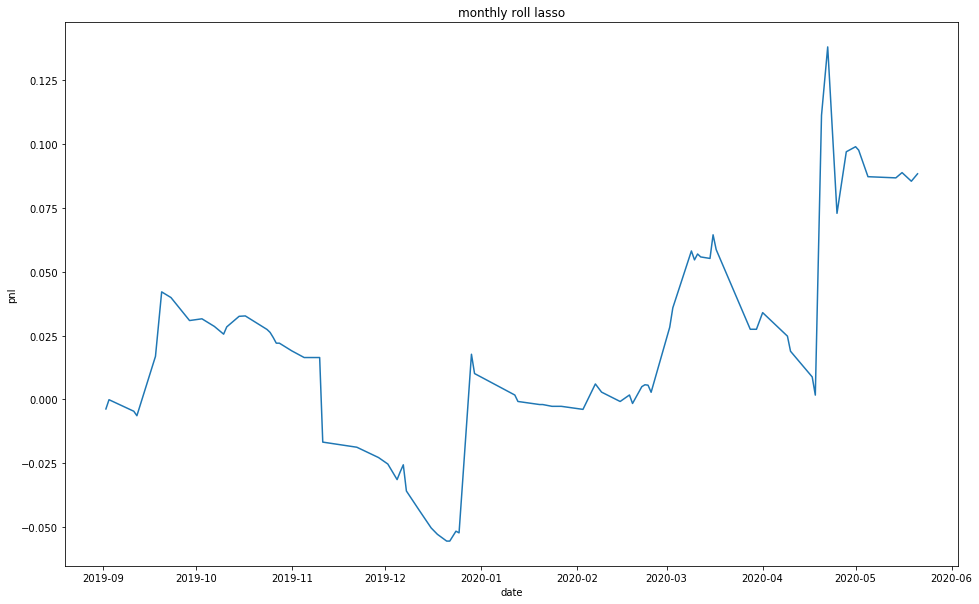

In [365]:
n_product = len(product_list[0:2])
save_path = "signal result atr"
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.crypto.lasso.4096"
start_month = 0
min_pnl = 10
min_num = 20
end_month = sum(month_len[0] < "2019-08")-1
all_pnl = np.array([])
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    train_mat = np.zeros((train_end-train_start+1, n_product))
    test_mat = np.zeros((forward_len, n_product))
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        train_mat[:,i_product] = train_pnl
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_pnl[np.isnan(test_pnl)]=0
        test_mat[:,i_product] = test_pnl
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    #parity_weight = risk_parity(train_mat)
    #diagonal_weight = risk_parity(train_mat, only_diag=True)
    avg_test_pnl = test_mat.mean(axis=1)
    #avg_test_pnl = np.dot(test_mat, sharpe_weight)
    #print(len(avg_test_pnl_mean)==len(avg_test_pnl))
    #avg_test_pnl = np.dot(test_mat, parity_weight)
    #avg_test_pnl = np.dot(test_mat, diagonal_weight)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    #print(all_pnl)
    #print(len(all_pnl), len(avg_test_pnl))
    start_month = start_month+1
    end_month = end_month+1
plt.figure(1, figsize=(16, 10))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], all_pnl.cumsum());
print("sharpe ", sharpe(all_pnl))

## sharpe  0.9119954426918262  ## avg
## sharpe  0.7391606833372824 ## sharpe
